# Mileage Prediction Problem

 This project aims to predict the mileage of cars based on features - cylinders, displacement, hp, weight, acceleration, model, origin and name.
 
 
We shall look at several methods from simple to more complex models to increase accuracy. Some of these models are: 

- Simple Regression
- Multiple Regression
- Ridge Regression
- K-Means Clustering

The data was obtained from  [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Auto+MPG)
There were about six rows with incomplete information which I deleted before I converted it to a .csv file. 

I'm going to use Graphlab to help me with the implementation of these models. 

In [5]:
import graphlab #Imports graphlab - If you haven't installed graplab, https://dato.com/download/

## Loading data

In [6]:
data = graphlab.SFrame('auto-mpg.csv') #Loads data and creates an SFrame (A datastructure which Graphlab uses)

2016-05-17 19:20:19,609 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.9 started. Logging: /tmp/graphlab_server_1463527218.log


Finished parsing file /Users/adityajp/Desktop/ML course/Mileage project/auto-mpg.csv

Parsing completed. Parsed 100 lines in 0.032468 secs.

This non-commercial license of GraphLab Create is assigned to ajayapra@uwaterloo.ca and will expire on January 25, 2017. For commercial licensing options, visit https://dato.com/buy/.
------------------------------------------------------

Finished parsing file /Users/adityajp/Desktop/ML course/Mileage project/auto-mpg.csv

Parsing completed. Parsed 392 lines in 0.014968 secs.


Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,float,int,int,float,int,int,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


In [4]:
data

mpg,cylinders,displacement,hp,weight,acceleration,model year,origin,name
18,8,307.0,130,3504,12.0,70,1,"""chevrolet chevellemalibu"" ..."
15,8,350.0,165,3693,11.5,70,1,"""buick skylark 320"""
18,8,318.0,150,3436,11.0,70,1,"""plymouth satellite"""
16,8,304.0,150,3433,12.0,70,1,"""amc rebel sst"""
17,8,302.0,140,3449,10.5,70,1,"""ford torino"""
15,8,429.0,198,4341,10.0,70,1,"""ford galaxie 500"""
14,8,454.0,220,4354,9.0,70,1,"""chevrolet impala"""
14,8,440.0,215,4312,8.5,70,1,"""plymouth fury iii"""
14,8,455.0,225,4425,10.0,70,1,"""pontiac catalina"""
15,8,390.0,190,3850,8.5,70,1,"""amc ambassador dpl"""


We're going to disregard the name of car and it's origin from our models. I don't feel the cars name or origin is important enough in this model.

# Plotting data

I feel it's somewhat important to plot some of the features against mpg (miles per gallon) to get a sense of data. Let's import pylot from matplotlib which helps with graphing data

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

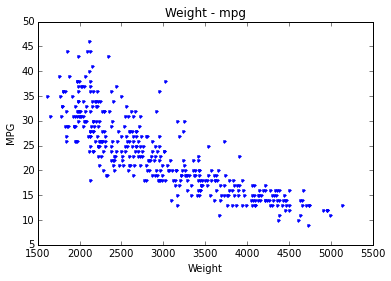

In [88]:
#Relation between weight and mpg. There certainly seems to be some connection. 

plt.plot(data['weight'],data['mpg'],'.')
plt.title('Weight - mpg')
plt.xlabel('Weight')
plt.ylabel('MPG')

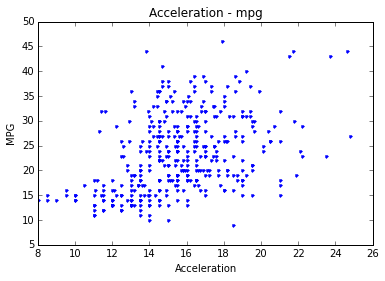

In [85]:

#Relation between acceleration and mpg. There's a lot of noise in this data.  

plt.plot(data['acceleration'],data['mpg'],'.')
plt.title('Acceleration - mpg')
plt.xlabel('Acceleration')
plt.ylabel('MPG')

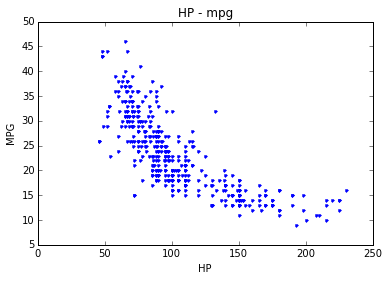

In [86]:
#Relation between hp and mpg. There's definitely some correlation.  

plt.plot(data['hp'],data['mpg'],'.')
plt.title('HP - mpg')
plt.xlabel('HP')
plt.ylabel('MPG')

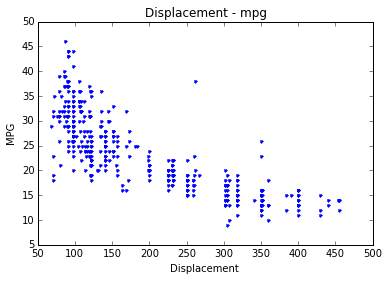

In [87]:
#Relation between displacement and mpg. There are gaps in the middle- this doesn't look good. 

plt.plot(data['displacement'],data['mpg'],'.')
plt.title('Displacement - mpg')
plt.xlabel('Displacement')
plt.ylabel('MPG')

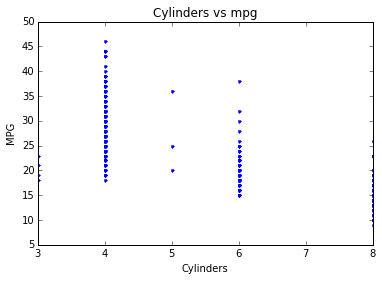

In [10]:
#Relation between Cylinder and mpg. It's best to disregard this info as well. 

plt.plot(data['cylinders'],data['mpg'],'.')
plt.title('Cylinders - mpg')
plt.xlabel('Cylinders')
plt.ylabel('MPG')

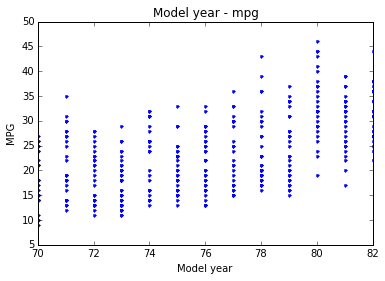

In [89]:
#Relation between Model year and mpg. 

plt.plot(data['model year'],data['mpg'],'.')
plt.title('Model year - mpg')
plt.xlabel('Model year')
plt.ylabel('MPG')

From the above graphs, it's clear that weight, hp and displacement add value to our model. 

The below function returns an SFrame. This will come in handy when we're thinking of higher order polynmials for our features. 

In [11]:
def polynomial_sframe(feature, degree, quantity):
    # initialize the SFrame:
    sframe = graphlab.SFrame()
    #Assign our s_frame the current feature. 
    sframe[quantity+'power_1'] = feature 
    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        # We want it to start at 2 and stop at degree
        for power in range(2, degree+1): 
            # first we'll give the column a name:
            name = quantity +'power_' + str(power)
            # then assign sframe[column_name] to the appropriate power of feature
            sframe[name] = feature**power

    return sframe

# Training, testing and validation data

It's important to split our data into three parts, training, testing and validation data. 
Our model trains on our training data and we run it on models of different complexities - validation data is used to tell us which complexity prevents overfitting. We finally predict testing data on our model to measure model accuracy. 

Another approach to checking whether our model is overfitted is to use k-cross validation, a measure which is more precise than the above approach. 

In [12]:
(training_and_validation, testing) = data.random_split(0.9,seed=0) #90% for testing and validation and 10% for testing
(training, validation) = data.random_split(0.5,seed=0) #90% of our data is evenly split between training and validation

# Simple Regression

In [13]:
def simple_linear_regression(input_feature, output):
    # compute the sum of input_feature and output
    input_sum = input_feature.sum()
    output_sum = output.sum()
    n = input_feature.size()
    # compute the product of the output and the input_feature and its sum
    product_sum = 0
    for i in range(0,n):
        product_sum+=(input_feature[i]*output[i])
    # compute the squared value of the input_feature and its sum
    input_square_sum = 0
    for i in input_feature:
        input_square_sum+=(i*i)
    # use the formula for the slope
    slope = (product_sum - (input_sum*output_sum/n))/(input_square_sum - input_sum*input_sum/n)
    # use the formula for the intercept
    intercept = output_sum/n - (slope*input_sum/n)
    
    return (intercept, slope)

def get_regression_predictions(input_feature, intercept, slope):
    # calculate the predicted values:
    predicted_values = intercept + input_feature*slope
    return predicted_values

#Residual sum of squares
def find_rss(predicted_output,output): 
    difference = predicted_output - output
    #Square each element in the SFrame
    difference = difference**2
    #Find the sum of all elements
    rss = difference.sum() 
    return rss

The point of using simple regression is to use a single feature to predict the house prices. Let's go ahead and see which is the best feature to reduce RSS. 

In [14]:
for i in ['weight','displacement','hp']:
    
    #Extract intercept and slope from model which is built on training data
    intercept,slope = simple_linear_regression(training[i],training['mpg'])
    
    #Function which predicts the value from the slope and intercept on testing data
    prediction = get_regression_predictions(testing[i], intercept, slope)
    
    #Finding the RSS
    rss = find_rss(prediction,testing['mpg'])
    print i, ": ", rss

weight :  18243545.0
displacement :  448.657038305
hp :  20776.0


For simple regression, displacement gives the most accurate result i.e., least RSS. 

Let's plot some of these values and understand the plots. 

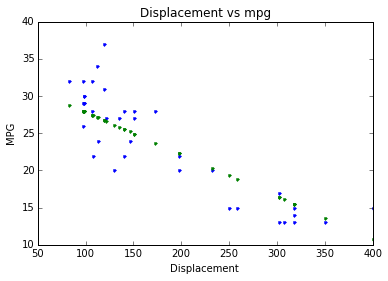

In [15]:
#Plotting predicted value of mpg from displacement

intercept,slope = simple_linear_regression(training['displacement'],training['mpg'])
prediction = get_regression_predictions(testing['displacement'], intercept, slope)

plt.plot(testing['displacement'],testing['mpg'],'.',
        testing['displacement'], prediction,'.')
plt.title('Displacement vs mpg')
plt.xlabel('Displacement')
plt.ylabel('MPG')

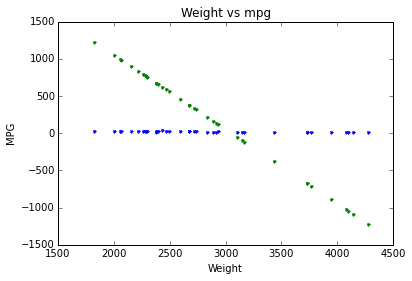

In [16]:
#Plotting predicted value of mpg from weight. Clearly doesn't fit. 


intercept,slope = simple_linear_regression(training['weight'],training['mpg'])
prediction = get_regression_predictions(testing['weight'], intercept, slope)

plt.plot(testing['weight'],testing['mpg'],'.',
        testing['weight'], prediction,'.')
plt.title('Weight vs mpg')
plt.xlabel('Weight')
plt.ylabel('MPG')

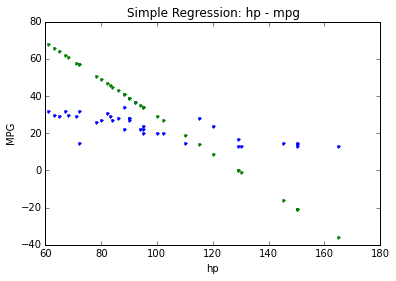

In [93]:
#Plotting predicted value of mpg from hp. Doesn't fit either. 


intercept,slope = simple_linear_regression(training['hp'],training['mpg'])
prediction = get_regression_predictions(testing['hp'], intercept, slope)

plt.plot(testing['hp'],testing['mpg'],'.',
        testing['hp'], prediction,'.')
plt.title('Simple Regression: hp - mpg')
plt.xlabel('hp')
plt.ylabel('MPG')

Probably simple regression isn't a great choice for our model. Let's try multiple regression next

# Multiple Regression

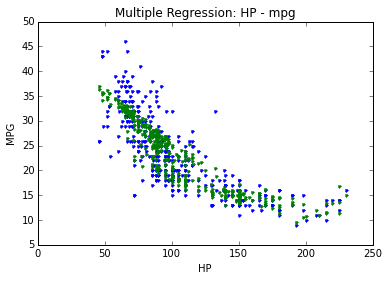

In [92]:
#Data to use weight, displacement, hp

#We're adding upto the 15th order polynomial of hp, weight and displacement
multi_data = polynomial_sframe(data['hp'],15,"hp") 
multi_data_weight = polynomial_sframe(data['weight'],15,"weight")
multi_data_disp = polynomial_sframe(data['displacement'],15,"displacement")

#Adding more columns to multi_data
multi_data.add_columns(multi_data_weight)
multi_data.add_columns(multi_data_disp)

#List of features
my_features = multi_data.column_names()
multi_data['mpg'] = data['mpg']
model = graphlab.linear_regression.create(multi_data, target = 'mpg', features = my_features, 
                                          validation_set = None, verbose=False)

#Let's see how our model performs with a 15th order polynomial on the entire dataset
plt.plot(multi_data['hppower_1'],multi_data['mpg'],'.',
        multi_data['hppower_1'], model.predict(multi_data),'.')
plt.title('Multiple Regression: HP - mpg')
plt.xlabel('HP')
plt.ylabel('MPG')

This is what multi data looks like, if we plot hp vs mpg. It fits it pretty well. 

In [49]:
multi_data

hppower_1,hppower_2,hppower_3,hppower_4,hppower_5,hppower_6,hppower_7
130,16900.0,2197000.0,285610000.0,37129300000.0,4.826809e+12,6.2748517e+14
165,27225.0,4492125.0,741200625.0,1.22298103125e+11,2.01791870156e+13,3.32956585758e+15
150,22500.0,3375000.0,506250000.0,75937500000.0,1.1390625e+13,1.70859375e+15
150,22500.0,3375000.0,506250000.0,75937500000.0,1.1390625e+13,1.70859375e+15
140,19600.0,2744000.0,384160000.0,53782400000.0,7.529536e+12,1.05413504e+15
198,39204.0,7762392.0,1536953616.0,3.04316815968e+11,6.02547295617e+13,1.19304364532e+16
220,48400.0,10648000.0,2342560000.0,5.153632e+11,1.13379904e+14,2.494357888e+16
215,46225.0,9938375.0,2136750625.0,4.59401384375e+11,9.87712976406e+13,2.12358289927e+16
225,50625.0,11390625.0,2562890625.0,5.76650390625e+11,1.29746337891e+14,2.91929260254e+16
190,36100.0,6859000.0,1303210000.0,2.476099e+11,4.7045881e+13,8.93871739e+15


At this point, we're unsure if a 15th order polynomial is right for our data. Let's find the right complexity for our. A very high order polynomial leads to overfitting i.e., our model works only well with our training set and doesn't perform well in the real world. 

In [20]:
import numpy as np

#rss_list stores a tuple containing degree and rss value 
rss_list = []

#going to consider polynomial upto the power of 15
for i in range(1,16):
    
    #Gathering necessary data from the training set
    poly_data = polynomial_sframe(training['hp'],i,"hp")
    poly_data.add_columns(polynomial_sframe(training['weight'],i,"weight"))
    poly_data.add_columns(polynomial_sframe(training['displacement'],i,"displacement"))
    #column_names
    my_features = poly_data.column_names()
    
    poly_data['mpg'] = training['mpg']

    #Creating a regression model 
    model = graphlab.linear_regression.create(poly_data, target = 'mpg', features = my_features, validation_set = None, verbose=False)
    
    #Getting necessary data from the validation set
    validation_data = polynomial_sframe(validation['hp'],i,"hp")
    validation_data.add_columns(polynomial_sframe(validation['weight'],i,"weight"))
    validation_data.add_columns(polynomial_sframe(validation['displacement'],i,"displacement"))
    
    #Predicted mpg
    prediction = model.predict(validation_data)
    
    #Computing the RSS (Residual sum of squares)
    difference = validation['mpg'] - prediction
    difference = difference ** 2 #Squaring all elements in the SFrame
    
    difference = np.array(difference) 
    rss = np.sum(difference)
    
    rss_list.append((rss,i)) #Append degree of the polynomial and RSS (Used for sorting later)

sorted_rss = sorted(rss_list, key=lambda tup: tup[0])    
degree = sorted_rss[0][1]

for i in sorted_rss:
    print i
#RSS is least for polynomial of degree 7 and highest for polynomial of degree 1 and RSS of degree 7 was found to be 3192 (approx)

(3191.8507493162506, 7)
(3193.6333369212625, 8)
(3210.3263883428162, 3)
(3213.1192394256623, 9)
(3218.2995731649835, 2)
(3226.2100058519532, 10)
(3227.0553529439294, 12)
(3228.0741428791434, 11)
(3230.681772101384, 13)
(3231.9992259291439, 6)
(3240.1715611568943, 14)
(3252.9277920464683, 15)
(3274.6487785211175, 4)
(3287.4535708717963, 5)
(3781.371176479639, 1)


We now know that our 7th order polynomial worked best on our validation set. Let's use it and compute the accuracy on our testing set. 

In [28]:
#Gathering testing data into an SFrame
def prediction(testing, model):
    testing_data = polynomial_sframe(testing['hp'],degree,"hp")
    testing_data.add_columns(polynomial_sframe(testing['weight'],degree,"weight"))
    testing_data.add_columns(polynomial_sframe(testing['displacement'],degree,"displacement"))
    testing_data.add_columns(polynomial_sframe(testing['acceleration'],degree,"acceleration"))
    #Prediction step
    testing_prediction = model.predict(testing_data)
    
    return (testing_prediction)

#Computing the RSS (Residual sum of squares)
test_prediction = prediction(testing, model)
difference = testing['mpg'] - test_prediction
difference = difference ** 2 #Squaring all elements in the SFrame
    
difference = np.array(difference) 
rss = np.sum(difference)

print rss


2321.40622431


The RSS is better on our testing data than our validation data. It's found to be 2321. 
Let's plot vs mpg on our testing set and see how it perfomed. 

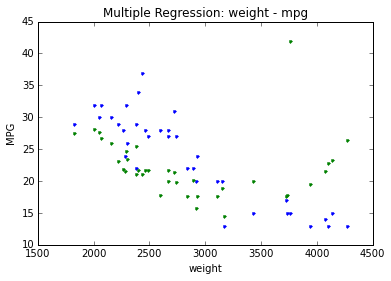

In [96]:
plt.plot(testing['weight'],testing['mpg'],'.',
        testing['weight'], test_prediction,'.')
plt.title('Multiple Regression: weight - mpg')
plt.xlabel('weight')
plt.ylabel('MPG')

# Ridge Regression

In ridge regression, we're gonna analyze the weight of our coefficients and maybe shrink them if they're too big. 
Let's write up a few functions which might help us in this process. 

In [46]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # Adding a constant column to our SFrame
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = graphlab.SFrame()
    for i in features:
        features_sframe[i] = data_sframe[i]
    #Convert SFrame to a feature matrix
    feature_matrix = features_sframe.to_numpy()
    #Assign the output
    output_sarray = data_sframe[output]
    #Convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    derivative = 2*(np.dot(errors, feature))
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    if feature_is_constant==False:
        derivative+= 2*l2_penalty*weight
    return derivative

def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    #Convert to a numpy array
    weights = np.array(initial_weights) 
    iteration=0
    #while not reached maximum number of iterations:
    while iteration < max_iterations:
        prediction = predict_output(feature_matrix,weights)
        errors = prediction -output
        #Update the value of each weight
        for i in xrange(len(weights)):
            if i==0:
                derivative = feature_derivative_ridge(errors, feature_matrix[:,i],weights[i],l2_penalty,True)
            else:
                derivative = feature_derivative_ridge(errors, feature_matrix[:,i],weights[i],l2_penalty,False)
            # compute the derivative for weight[i].
            weights[i]-=step_size*derivative
        iteration+=1
    return weights

def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is also a numpy array
    predictions = np.dot(feature_matrix, weights)
    return(predictions)

Let's define some of our features and have the complexity be 7

In [44]:
model_features = ['weight', 'hp','displacement'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'mpg'
(feature_matrix, output) = get_numpy_data(training, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(testing, model_features, my_output)
initial_weights = np.array([0.0,0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

Let's set out l2_penalty to different values

In [47]:
l2_penalty = 0.0
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations)
print multiple_weights_0_penalty

[  3.11951830e-06   6.21662862e-03   2.00509823e-04   2.36593783e-04]


In [48]:
l2_penalty = 1e11
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations)
print multiple_weights_high_penalty

[  8.30525479e-06   1.15858506e-04   4.01153603e-06   7.17626637e-06]


Lets make RSS prediction on three weights - initial weight, low regularization and high regularization

In [52]:
predict_initial = predict_output(test_feature_matrix, initial_weights)
predict_low_penalty = predict_output(test_feature_matrix, multiple_weights_0_penalty)
predict_high_penalty = predict_output(test_feature_matrix, multiple_weights_high_penalty)

Let's compute the RSS from the three above predictions using our find_rss which we wrote under simple regression

In [56]:
rss_initial_weight = find_rss(predict_initial,test_output)
rss_low_penalty = find_rss(predict_low_penalty,test_output)
rss_high_penalty = find_rss(predict_high_penalty,test_output)

print rss_initial_weight
print rss_low_penalty
print rss_high_penalty

22745.0
5718.07941601
22200.147319


With this dataset, it's best if we stick with a penalty of 0 for our l2_penalty to keep RSS to a minimum. Our multiple regression model seems to outperform this one in terms of minimizing RSS. I don't think this model did a great job at predicting mpg. 

# K-Means Clustering 

Lets define a few functions which we will use for our algorithm. 

In [58]:
def normalize_features(feature_matrix):
    x = np.array(feature_matrix)
    norms = np.linalg.norm(x,axis=0)
    return (x/norms,norms)

In [61]:
features_train, output_train = get_numpy_data(training, model_features, 'mpg')
features_test, output_test = get_numpy_data(testing, model_features, 'mpg')
features_valid, output_valid = get_numpy_data(validation, model_features, 'mpg')

Normalizing data is very important because some features might have larger weights that others and this could lead to errors. 

In [62]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

In [68]:
#Computes the euclidian distance from the query object to all other objects
import numpy as np
def distances(features_train,query):
    diff = features_train[:] - query
    distance = np.sum(diff**2,axis=1)
    distance = np.sqrt(distance)
    return (distance)

In [69]:
#Implemenatation for k-nearest neighbours
def knearest(features_train,query_set,k,output):
    predicted_values = []
    for j in range(0,len(query_set)):
        #Computes the euclidian distance
        distance = distances(features_train,query_set[j])
        dist_vector = []
        for i in range(0,len(distance)):
            dist_vector.append((distance[i],i))
        
        #Sorts the information in ascending order
        sort = sorted(dist_vector, key=lambda tup: tup[0])
        keys = [i[1] for i in sort]
        value=0
        
        #Finds the average of k nearest objects
        for i in keys[:k]:
            value+=output[i]
        value/=k
        predicted_values.append((value,j))
    return predicted_values

With this dataset, we don't know what the value of k needs to be, let's look at which value of k gives the least error. 

In [73]:
rss_list = []

#RSS for values of k from 1 to 15
for k in range(1,16):
    #Predicted value on validation set
    prediction = knearest(features_train,features_valid,k,output_train)
    pred_list = [i[0] for i in prediction]
    rss_list.append((find_rss(pred_list,output_valid),k))

#Let's sort and print the RSS value for each value of k
rss_all=[]
for i in rss_list:
    rss_all.append(i[0])
sort = sorted(rss_list,key=lambda tup:tup[0])
k = sort[0][1]
for i in sort:
    print i

(3085, 13)
(3093, 15)
(3094, 14)
(3136, 8)
(3138, 7)
(3175, 11)
(3206, 9)
(3220, 10)
(3259, 12)
(3263, 6)
(3392, 5)
(3468, 4)
(4009, 3)
(4132, 2)
(5809, 1)


Looks like k=13 has the least RSS value. Let's plot the values.

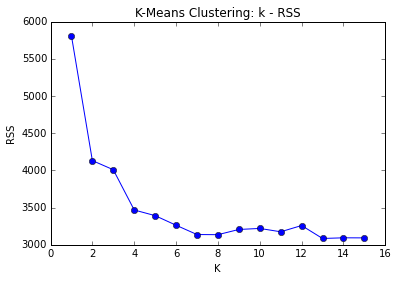

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(1, 16)
plt.plot(kvals, rss_all,'bo-')
plt.title('K-Means Clustering: k - RSS')
plt.xlabel('K')
plt.ylabel('RSS')

Finally, let's find RSS on testing data and see if k-means can outperform multiple regression for this dataset. 

In [77]:
#Running RSS on testing data to measure accuracy of this model

prediction = knearest(features_train,features_test,k,output_train)
pred_list = [i[0] for i in prediction]
print find_rss(pred_list,output_test)

439


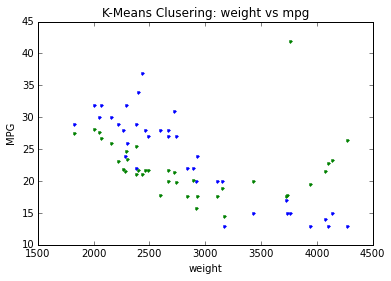

In [98]:
plt.plot(testing['weight'],output_test,'.',
        testing['weight'], test_prediction,'.')
plt.title('K-Means Clusering: weight vs mpg')
plt.xlabel('weight')
plt.ylabel('MPG')

Let's compare the different values of RSS and see which model performed best for this model based on the testing data

- Simple Regression - 448 (displacement was the only feature)
- Multiple Regression - 2321
- Ridge Regression - 5718 (Worst performing model for this dataset)
- K-means Clustering - 439 (Best performing model for this dataset)

For this dataset, simple regression beat multiple regression - I didn't expect that to happen. 

I had some intuition before coding that k-means clustering was certainly gong to outperform every other method because this data seems like it's meant for k-means clustering which also happens to be my favourite ML algorithm. It's super intuitive and I'm sure most people have used it in their day-to-day lives without realising it. 